# Supervised Learning:
## COVID, FLU, COLD Symptoms
### Project for Artificial Intelligence Class in the Faculty of Engineering of University of Porto
The given problem consists of a dataset of symptoms and associated diseases that can be either Covid-19, Flu, Common Cold or Allergy.

The goal of the machine learning model is to determine what's the most probable disease an infected person has based on their symptoms.

This problem can be interpreted as a classification problem with four classes: Allergy, Covid, Flu and Cold, as well as twenty binary-valued attributes corresponding to the studied symptoms.

Due to the nature of the dataset (having only binary values, meaning if a symptom present or not), the methods that are best suited for it and the reasons why are the following: 

- Decision Trees: It's the most similar method to how a doctor would do a diagnosis

- Support Vector Machines: Since we have 20 attributes, this algorithm is adequate to the multidimensional space of our classification problem, using the kernel trick. We will test both One-to-One and One-to-Rest approaches.  

- Logistic Regression: A model built to be fit to binary data and commonly used in the medical industry for similar problems
###### By: Daniel Garcia Silva, Iohan Sardinha and João Mascarenhas




# Importing necessary libraries

In [1]:
%matplotlib inline
import time
import pandas as pd
import matplotlib.pyplot  as plt
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report

# Loading dataframe

In [2]:
diseases = pd.read_csv("large_data.csv")
diseases.sample(frac=1).head()

,COUGH,MUSCLE_ACHES,TIREDNESS,SORE_THROAT,RUNNY_NOSE,STUFFY_NOSE,FEVER,NAUSEA,VOMITING,DIARRHEA,...,DIFFICULTY_BREATHING,LOSS_OF_TASTE,LOSS_OF_SMELL,ITCHY_NOSE,ITCHY_EYES,ITCHY_MOUTH,ITCHY_INNER_EAR,SNEEZING,PINK_EYE,TYPE
28336,0,1,1,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,FLU
1951,0,0,1,1,1,1,0,0,0,0,...,0,1,1,1,1,1,1,1,1,ALLERGY
15903,0,0,0,1,1,1,0,0,0,0,...,0,1,0,0,0,1,0,1,0,ALLERGY
31347,0,0,1,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,FLU
1488,1,1,1,1,1,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,ALLERGY


# Data Analisys
## Separating desease by type

In [3]:
flu = diseases[diseases.TYPE == "FLU"].drop(columns=["TYPE"])
covid = diseases[diseases.TYPE == "COVID"].drop(columns=["TYPE"])
cold = diseases[diseases.TYPE == "COLD"].drop(columns=["TYPE"])
allergy = diseases[diseases.TYPE == "ALLERGY"].drop(columns=["TYPE"])

## Plotting each disease's number of symptoms
This is done to look for outliers, meaning some single case that had a symptom that the large majority of cases of the same disease didn't have.

### Flu

<BarContainer object of 20 artists>

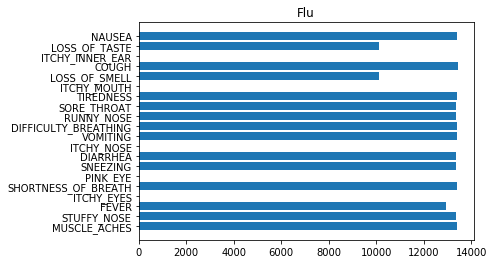

In [4]:
flu_dict = flu.sum().to_dict()
#plt.xlim([0, 10]) # <-- this was to make the graph clearer, when looking for small numbers (outliers)
plt.title("Flu")
plt.barh(flu_dict.keys(), flu_dict.values())

### Covid

<BarContainer object of 20 artists>

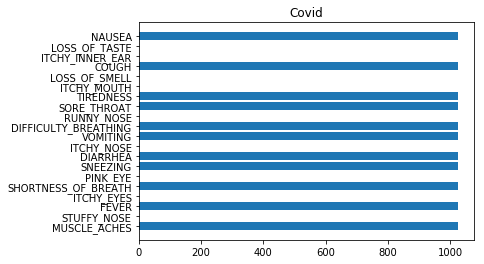

In [5]:
covid_dict = covid.sum().to_dict()
#plt.xlim([0, 10]) # <-- this was to make the graph clearer, when looking for small numbers (outliers)
plt.title("Covid")
plt.barh(covid_dict.keys(), covid_dict.values())

### Cold

<BarContainer object of 20 artists>

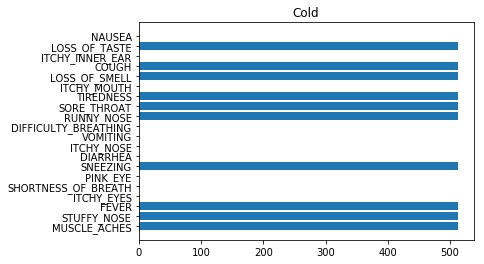

In [6]:
cold_dict = cold.sum().to_dict()
#plt.xlim([0, 10]) # <-- this was to make the graph clearer, when looking for small numbers (outliers)
plt.title("Cold")
plt.barh(cold_dict.keys(), cold_dict.values())

### Allergy

<BarContainer object of 20 artists>

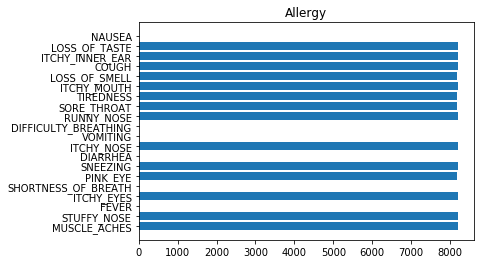

In [7]:
allergy_dict = allergy.sum().to_dict()
#plt.xlim([0, 10]) # <-- this was to make the graph clearer, when looking for small numbers (outliers)
plt.title("Allergy")
plt.barh(allergy_dict.keys(), allergy_dict.values())

### All diseases

<BarContainer object of 20 artists>

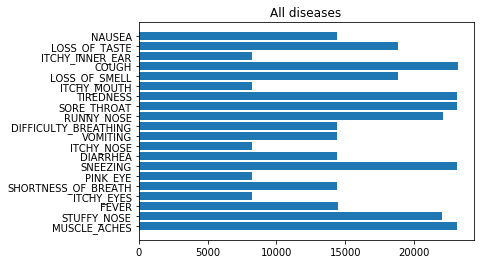

In [8]:
diseases_dict = diseases.drop(columns=["TYPE"]).sum().to_dict()
#plt.xlim([0, 10]) # <-- this was to make the graph clearer, when looking for small numbers (outliers)
plt.title("All diseases")
plt.barh(diseases_dict.keys(), diseases_dict.values())

## Plotting the number of cases of each desease

<BarContainer object of 4 artists>

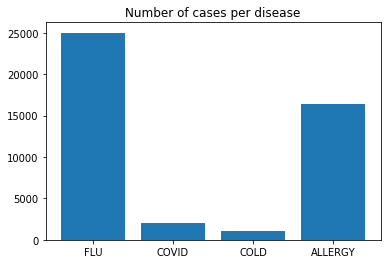

In [9]:
plt.title("Number of cases per disease")
plt.bar(["FLU", "COVID", "COLD", "ALLERGY"], [len(flu),len(covid),len(cold),len(allergy)])

### Conclusion
There's no apparent outlier in the given dataset, since all diseases seem to have a similar set of symptoms per case.
The number of cases of each desease differs a lot, so this must be taken in account when splitting the data.

# Data Splitting
When splitting in test and train data, the *stratify* attribute is set to *all_labels* in order to keep the same proportion of each label in the splits 

In [10]:
all_inputs = diseases.drop(columns=["TYPE"]).values
all_labels = diseases['TYPE'].values

(training_inputs, 
 testing_inputs, 
 training_classes, 
 testing_classes) = train_test_split(all_inputs, all_labels, stratify=all_labels, test_size=0.3, random_state=1)

# Creating models
## Decision Tree Learning  

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression.  
The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.  
A tree can be seen as a piecewise constant approximation.

Some of its advantages are:
- Robust to noise (especially when methods to avoid overfitting are
employed)
- Can easily handle redundant and irrelevant attributes.
- Extremely fast at classifying unknown records and inexpensive.

And disadvantages: 
- Each decision boundary involves only a single attribute.
- Due to the greedy nature of splitting criterion, interacting
attributes (that can distinguish between classes together but not
individually) may be passed over in favor of other attributed that
are less discriminating.


### Parameter Tuning  

In [11]:
#from joblib import parallel_backend

#with parallel_backend('threading', n_jobs=-1):

#    dtree_classifier = DecisionTreeClassifier()
    

#    parameter_grid = {   'criterion': ['gini', 'entropy'],
#                         'splitter': ['best', 'random'],
#
#                         'max_depth': [1, 2, 3, 4, 5,6,7,8,9,10,15,20],
#                         'max_features': [1, 2, 3, 4,5,6,7,8,9,10,11,12],
#                         'class_weight':['balanced', None],
#                            }

#    cross_validation = StratifiedKFold(n_splits=10)

#    grid_search = GridSearchCV(dtree_classifier, param_grid=parameter_grid, cv=cross_validation, verbose=3, n_jobs=-1)

#    grid_search.fit(all_inputs, all_labels)
#    print('Best score: {}'.format(grid_search.best_score_))
#    print('Best parameters: {}'.format(grid_search.best_params_))

### Training the Model
The best parameters are : {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': 12, 'splitter': 'best'} with 0.928 as the best score

In [12]:
start = time.time()

dtree_classifier = DecisionTreeClassifier(criterion='gini',splitter='best',max_depth=15, max_features=12,class_weight='balanced')
dtree_classifier.fit(training_inputs, training_classes)
dtree_pred = dtree_classifier.predict(testing_inputs)

end = time.time()
print("Dtree time: "+ str(end - start) + " seconds")

Dtree time: 0.0859999656677 seconds


### Accuracy Score

In [13]:
dtree_accuracy_score = accuracy_score(testing_classes, dtree_pred)

print("Accuracy score (Dtree): "+ str(dtree_accuracy_score))

Accuracy score (Dtree): 0.9210407918416317


### Confusion Matrix

In [14]:
print(confusion_matrix(testing_classes, dtree_pred))

[[4758  156    0    0]
 [   0  307    0    0]
 [   0   25  406  184]
 [   0  140  548 6812]]


### Classification Report

In [15]:
targets = ["FLU", "COLD", "COVID", "ALLERGY"]

dtree_report = classification_report(testing_classes, dtree_pred, target_names=targets, output_dict=True)

print(classification_report(testing_classes, dtree_pred, target_names=targets))

              precision    recall  f1-score   support

         FLU       1.00      0.97      0.98      4914
        COLD       0.49      1.00      0.66       307
       COVID       0.43      0.66      0.52       615
     ALLERGY       0.97      0.91      0.94      7500

   micro avg       0.92      0.92      0.92     13336
   macro avg       0.72      0.88      0.77     13336
weighted avg       0.95      0.92      0.93     13336



## SVM
Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.

The advantages of support vector machines are:

- Effective in high dimensional spaces.

- Still effective in cases where number of dimensions is greater than the number of samples.

- Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.

- Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

The disadvantages of support vector machines include:

- If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.

- SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation (see Scores and probabilities, below).

###    Parameter Tuning

In [16]:
#from joblib import parallel_backend

##with parallel_backend('threading', n_jobs=-1):

##    svm_classifier = svm.SVC()

##    parameter_grid = {'kernel': ['poly', 'rbf'],
##                            'degree': [1, 2, 3, 4],
##                            'C': [0.1, 1, 10],
##                            'gamma': [0.1, 1]}

##    cross_validation = StratifiedKFold(n_splits=10)

##    grid_search = GridSearchCV(svm_classifier, param_grid=parameter_grid, cv=cross_validation, verbose=3, n_jobs=-1)

##    grid_search.fit(all_inputs, all_labels)
##    print('Best score: {}'.format(grid_search.best_score_))
##    print('Best parameters: {}'.format(grid_search.best_params_))

### Training the model

In [17]:
start = time.time()

svm_model = svm.SVC(C=1, degree=1, gamma=0.1, kernel='poly')
svm_model.fit(training_inputs, training_classes)
svm_pred = svm_model.predict(testing_inputs)

end = time.time()
print("SVM time: "+ str(end - start) + " seconds")

SVM time: 10.2779998779 seconds


### Accuracy Score

In [18]:
svm_accuracy_score = accuracy_score(testing_classes, svm_pred)

print("Accuracy score (SVM): "+ str(svm_accuracy_score))

Accuracy score (SVM): 0.9294391121775645


### Confusion Matrix

In [19]:
print(confusion_matrix(testing_classes, svm_pred))

[[4914    0    0    0]
 [ 158  142    7    0]
 [  13    5  284  313]
 [  75   62  308 7055]]


### Classification Report

In [20]:
targets = ["FLU", "COLD", "COVID", "ALLERGY"]

svm_report = classification_report(testing_classes, svm_pred, target_names=targets, output_dict=True)

print(classification_report(testing_classes, svm_pred, target_names=targets))

              precision    recall  f1-score   support

         FLU       0.95      1.00      0.98      4914
        COLD       0.68      0.46      0.55       307
       COVID       0.47      0.46      0.47       615
     ALLERGY       0.96      0.94      0.95      7500

   micro avg       0.93      0.93      0.93     13336
   macro avg       0.77      0.72      0.74     13336
weighted avg       0.93      0.93      0.93     13336



## Logistic Regression
Logistic regression, despite its name, is a linear model for classification rather than regression. 

Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

This implementation can fit binary, One-vs-Rest, or multinomial logistic regression with optional *l1*, *l2* or Elastic-Net regularization.

### Parameter tuning

In [21]:
#from joblib import parallel_backend

#with parallel_backend('threading', n_jobs=-1):

#    logit_classifier = LogisticRegression()

#    parameter_grid = {'penalty': ['l1', 'l2'],
#                  'class_weight':['balanced', None],
#                   'C': [0.1, 1, 10],
#                   'fit_intercept':[True, False],
#                    'max_iter': [100,500,1000]}

#    cross_validation = StratifiedKFold(n_splits=10)

#    grid_search = GridSearchCV(logit_classifier, param_grid=parameter_grid, cv=cross_validation, verbose=3, n_jobs=-1)

#    grid_search.fit(all_inputs, all_labels)
#    print('Best score: {}'.format(grid_search.best_score_))
#    print('Best parameters: {}'.format(grid_search.best_params_))

### Training the model

Since the deseases have an unequal amout of occurencies the parameter class_weigth is set to 'balanced':
    
    The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)). 

In [31]:
start = time.time()

logit_model = LogisticRegression(C=0.1,class_weight='balanced')
logit_model.fit(training_inputs, training_classes)
logit_pred = logit_model.predict(testing_inputs)

end = time.time()
print("Logit time: "+ str(end - start) + " seconds")

Logit time: 0.546999931335 seconds


### Accuracy Score

In [23]:
logit_accuracy_score = accuracy_score(testing_classes, logit_pred)

print("Accuracy score (Logit): "+ str(logit_accuracy_score))

Accuracy score (Logit): 0.9321385722855429


### Confusion Matrix

In [24]:
print(confusion_matrix(testing_classes, logit_pred))

[[4758  155    1    0]
 [   0  306    1    0]
 [   0   24  534   57]
 [   0  140  527 6833]]


### Classification Report

In [25]:
logit_report = classification_report(testing_classes, logit_pred, target_names=targets, output_dict=True)
print(classification_report(testing_classes, logit_pred, target_names=targets))

              precision    recall  f1-score   support

         FLU       1.00      0.97      0.98      4914
        COLD       0.49      1.00      0.66       307
       COVID       0.50      0.87      0.64       615
     ALLERGY       0.99      0.91      0.95      7500

   micro avg       0.93      0.93      0.93     13336
   macro avg       0.75      0.94      0.81     13336
weighted avg       0.96      0.93      0.94     13336



# Comparing Models
#### Some functions for making plotting easier

In [26]:
def plotReport(field, dtree_ ,svm_, logit, limit=0.4, limit2=1.09):
    x = np.arange(len(targets))
    width = 0.2

    fig, ax = plt.subplots()

    rects1 = ax.bar(x, dtree_, width, label='Decision tree')
    rects2 = ax.bar(x + width, svm_, width, label='SVM')
    rects3 = ax.bar(x - width, logit, width, label='Logit')

    ax.set_ylabel('%')
    ax.set_title(field.capitalize()+' by model')
    ax.set_xticks(x)
    ax.set_xticklabels(targets)
    ax.set_ylim(limit, limit2)
    ax.yaxis.grid(True, linestyle=':')
    ax.legend()

    return plt.show()

In [27]:
def getReport(field, report):
    return [report['FLU'][field],report['COLD'][field],report['COVID'][field],report['ALLERGY'][field]]

## Comparing precision

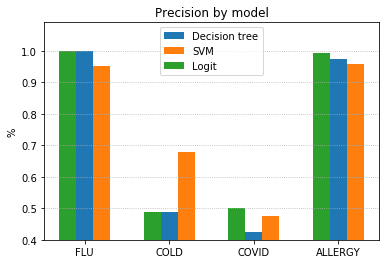

In [28]:
field = 'precision'
svm_precision = getReport(field, svm_report)
logit_precision = getReport(field, logit_report)
dtree_precision = getReport(field, dtree_report)


plotReport(field,dtree_precision, svm_precision, logit_precision)

## Comparing Recall

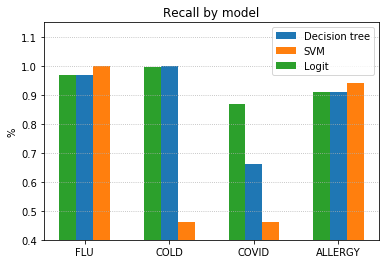

In [29]:
field = 'recall'
svm_precision = getReport(field, svm_report)
logit_precision = getReport(field, logit_report)
dtree_precision = getReport(field, dtree_report)


plotReport(field,dtree_precision, svm_precision, logit_precision,limit2=1.15)

## Comparing f1-score

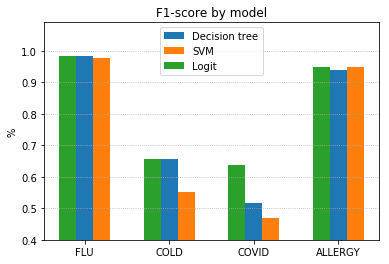

In [30]:
field = 'f1-score'
svm_precision = getReport(field, svm_report)
logit_precision = getReport(field, logit_report)
dtree_precision = getReport(field, dtree_report)


plotReport(field,dtree_precision, svm_precision, logit_precision)

# Conclusions
Logit got better overall precisions but not by much, while SVM got more balanced predictions. When it comes to the Decision Tree classifier, it got scores halfway between the Svm and the Logit classifiers.
If the goal was to predict Covid-19 cases in opposition to other diseases, all three achieved low precision, with a slightly better performance for logistic regression.